# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

## Data Exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

BATCH_SIZE = 32

data_transforms = transforms.ToTensor()
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 18165135/18165135 [00:15<00:00, 1203731.17it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 186955.91it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 903869.69it/s] 


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 4533425.48it/s]


Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



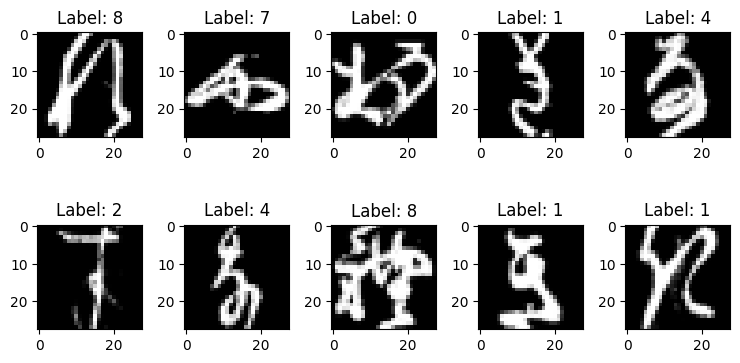

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [2]:

num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

# Fully Connected NN

In [3]:
def calculate_accuracy(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the class with the highest probability
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [12]:

class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input except batch dimension
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#hyparameters
input_size = 28 * 28
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
num_classes = 10

# Initialize the model
model = FullyConnectedNN(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
test_losses = []
accuracy_train=[]
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_acc=calculate_accuracy(model,trainloader)
    accuracy_train.append(train_acc)
    test_loss = calculate_accuracy(model, testloader)
    test_losses.append(test_loss)
    train_losses.append(running_loss/len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")


Epoch 1, Loss: 0.47425747440407673
Epoch 2, Loss: 0.3188936768533041
Epoch 3, Loss: 0.2794074609177808
Epoch 4, Loss: 0.24323905887296424
Epoch 5, Loss: 0.22890712239934752


### Accuracy

In [10]:
accuracy_training = calculate_accuracy(model, trainloader)
print(f"Accuracy on training data: {accuracy_training:.4f}")

accuracy= calculate_accuracy(model,testloader)
print(f"Accuracy on test data: {accuracy:.4f}")


Accuracy on training data: 0.9948
Accuracy on test data: 0.9097


## plot of the model

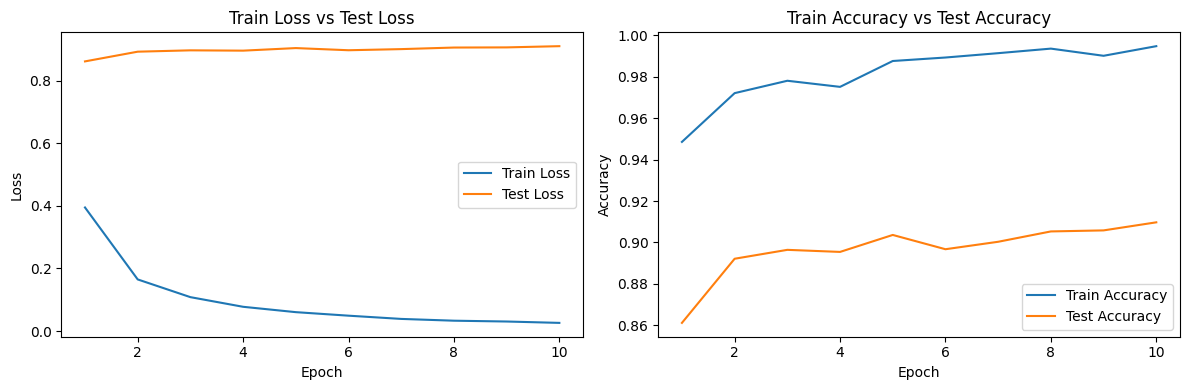

In [11]:
# Plotting train losses and test losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()

# Plotting accuracy of train and test
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_train, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Convolution NN

In [5]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Update this line
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model2=CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in trainloader:
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model2(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.2334
Epoch 2/10, Loss: 0.0713
Epoch 3/10, Loss: 0.0396
Epoch 4/10, Loss: 0.0261
Epoch 5/10, Loss: 0.0175
Epoch 6/10, Loss: 0.0128
Epoch 7/10, Loss: 0.0115
Epoch 8/10, Loss: 0.0078
Epoch 9/10, Loss: 0.0079
Epoch 10/10, Loss: 0.0078


In [6]:
accuracy = calculate_accuracy(model2, trainloader)
print(f"Accuracy on validation data: {accuracy:.4f}")

Accuracy on validation data: 0.9990
